## TENSOR FLOW PARA PRINCIPIANTES (IV): Guardar y Recuperar grafos con TensorFlow



Este tutorial muestra cómo guardar y restaurar las variables de una red neuronal cread en TensorFlow. Durante la optimización guardamos las variables de la red neuronal siempre que su precisión de clasificación haya mejorado en el conjunto de validación. La optimización se cancela cuando no ha habido mejoras para 1000 iteraciones. Luego, volvemos a cargar las variables que obtuvieron mejores resultados en el conjunto de validación.

Esta estrategia se llama **Early Stopping**. Se usa para evitar el sobreajuste (Overfitting) de la red neuronal. Esto ocurre cuando la red neuronal se está entrenando durante demasiado tiempo, por lo que comienza a aprender el ruido del conjunto de entrenamiento, lo que podría causar que la red neuronal clasifique incorrectamente las imágenes nuevas.

El sobreajuste no es realmente un problema para la red neuronal utilizada en este tutorial en el conjunto de datos MNIST para el reconocimiento de dígitos escritos a mano. Pero este tutorial muestra la idea general en el uso del **Early Stopping** cómo técnica.


Seguiremos utilizando el ejemplo usado en los tutoriales anetrioeres (ver tutoriales [I],[II],[III],[IV]) para mostrar como guardar y recuperar las variables de la red neuronal. Partamos del mismo  esquema de la red neuronal convolucinal que queremos implementar para la tarea del reconocimiento de dígitos escritos a mano, para terner presente la estructura de nuestra red, tal y como hemos encho en los tutoriales anteriores. 


![F1](imagenes/02_network_flowchart.png)

[I]:https://www.apsl.net/blog/2017/12/05/tensor-flow-para-principiantes-i/
[II]:https://www.apsl.net/blog/2017/12/18/tensor-flow-para-principiantes-ii/
[III]:https://www.apsl.net/blog/2018/01/10/tensor-flow-para-principiantes-iii-uso-de-la-libreria-prettytensor/
[IV]:https://www.apsl.net/blog/2018/01/19/tensor-flow-para-principiantes-iv-uso-de-la-api-layers/


Importamos las librerias. Utilizaremos la libreria PrettyTensor para simplificar la construcción de redes neuronales (ver tutorial [III] para más detalles).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

Cargamos los datos

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Las etiquetas de clase son codificadas por One-Hot, lo que significa que cada etiqueta es un vector con 10 elementos, todos los cuales son cero a excepción de un elemento. El índice de este elemento es el número de clase, es decir, el dígito que se muestra en la imagen asociada. También necesitamos los números de clase como enteros para el conjunto de pruebas, por lo que ahora lo calculamos.


In [3]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

Pasamos a definir el conjunto de variables para dar formato a las dimensiones de nuestras imágenes:

In [4]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

 Crearemos nuestra función que es utilizada para trazar 9 imágenes en una cuadrícula de 3x3 y escribir las clases verdaderas y predichas debajo de cada imagen.


In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

graficamos algunos datos

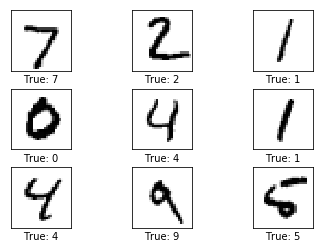

In [6]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

Las variables de marcador de posición (Placeholder variables)

Creamos las variables de marcador de posición como hicimos en los tutoriales anteriores:


In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
#y_true_cls = tf.argmax(y_true, dimension=1)
y_true_cls = tf.argmax(y_true, axis=1)

Creamos la estructura de la red neuronal

Esta sección implementa la Red Neural Convolucional usando Pretty Tensor (veáse Tutorial [III]).

In [8]:
x_pretty = pt.wrap(x_image)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Creamos nuestra función para obtener los pesos de los filtros

In [9]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')




método de optimización en la función de coste:

In [10]:
# Optimization Method
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

Medidas de desempeño

In [11]:
#y_pred_cls = tf.argmax(y_pred, dimension=1)
y_pred_cls = tf.argmax(y_pred, axis=1)

Luego creamos un vector de booleanos que nos dice si la clase predicha es igual a la clase verdadera de cada imagen.

In [12]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Calculamos la precisión (accuracy) de la clasificación y transforma los booleanos a floats, de modo que False se convierte en 0 y True se convierte en 1. Luego calculamos el promedio de estos números.

In [13]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Guardar las variables del grafo

Para guardar las variables de la red neuronal, ahora creamos objeto que llamaremos Saver, que se utiliza para almacenar y recuperar todas las variables del gráfico TensorFlow. Nada se guarda realmente en este punto, lo que se hará más adelante en la función optimize ().

In [14]:
saver = tf.train.Saver()

Los archivos guardados a menudo se llaman puntos de control porque pueden escribirse a intervalos regulares durante la optimización.

Este es el directorio utilizado para guardar y recuperar los datos.

In [15]:
save_dir = 'checkpoints/'

Crea el directorio si no existe.

In [16]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Esta es la ruta para el archivo punto de control.

In [17]:
save_path = os.path.join(save_dir, 'best_validation')

###  Ejecutamos el grafo de TensorFlow 
Crear sesión de TensorFlow

Una vez que se ha creado el gráfico TensorFlow, y todos los elementos necesario para su ejecución,  tenemos que crear una sesión TensorFlow que se utiliza para ejecutar el grafo.

In [18]:
session = tf.Session()

# Initialize variables
def init_variables():
    session.run(tf.global_variables_initializer())
    
#Execute the function now to initialize the variables.
init_variables()

creamos la función de iteración para el proceso de optimización, esta vez agregaremos un par de aspectos más ya que ahora consideraremos la opción de guardar:

In [19]:
train_batch_size = 64

La precisión de clasificación para el conjunto de validación se calculará por cada 100 iteraciones de la función de optimización a continuación. La optimización se detendrá si la precisión de la validación no se ha mejorado en 1000 iteraciones. Necesitamos algunas variables para hacer un seguimiento de esto.

In [20]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

Función para realizar una serie de iteraciones de optimización a fin de mejorar gradualmente las variables de las capas de red. En cada iteración, se selecciona un nuevo lote de datos del conjunto de entrenamiento y luego TensorFlow ejecuta el optimizador usando esas muestras de entrenamiento. El progreso se imprime cada 100 iteraciones donde la precisión de la validación también se calcula y se guarda en un archivo si se trata de una mejora.

In [21]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variables rather than local copies.
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Increase the total number of iterations performed.
        # It is easier to update it in each iteration because
        # we need this number several times in the following.
        total_iterations += 1

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if (total_iterations % 100 == 0) or (i == (num_iterations - 1)):

            # Calculate the accuracy on the training-batch.
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)

            # Calculate the accuracy on the validation-set.
            # The function returns 2 values but we only need the first.
            acc_validation, _ = validation_accuracy()

            # If validation accuracy is an improvement over best-known.
            if acc_validation > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = acc_validation
                
                # Set the iteration for the last improvement to current.
                last_improvement = total_iterations

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=session, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
            
            # Status-message for printing.
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"

            # Print it.
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # If no improvement found in the required number of iterations.
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")

            # Break out from the for-loop.
            break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Ahora crearemos algunas funciones para el monitoreo del comportamiento del modelo.
 * Función para trazar ejemplos de imágenes del conjunto de prueba que han sido clasificadas incorrectamente.



In [22]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

* Función para calcular la matriz de confusión 

In [23]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

* funciones para calcular clasificaciones

   * Esta función calcula las clases de imágenes predichas y también devuelve una matriz booleana si la clasificación de cada imagen es correcta.

   * El cálculo se realiza en lotes porque, de lo contrario, podría usar demasiada memoria RAM. Si su computadora falla, puede intentar bajar el tamaño del lote.

In [24]:


# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred



* Función que calcule la clase predicha para el conjunto de prueba.

In [25]:
def predict_cls_test():
    return predict_cls(images = data.test.images,
                       labels = data.test.labels,
                       cls_true = data.test.cls)



* Calcule la clase predicha para el conjunto de validación.

In [26]:
def predict_cls_validation():
    return predict_cls(images = data.validation.images,
                       labels = data.validation.labels,
                       cls_true = data.validation.cls)

Función para la precisión de clasificación

Esta función calcula la precisión de clasificación dada una matriz booleana si cada imagen fue clasificada correctamente. P.ej. cls_accuracy ([True, True, False, False, False]) = 2/5 = 0.4

In [27]:
def cls_accuracy(correct):
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum

* Calcule la precisión de clasificación en el conjunto de validación.

In [28]:
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    # The function returns two values but we only need the first.
    correct, _ = predict_cls_validation()
    
    # Calculate the classification accuracy and return it.
    return cls_accuracy(correct)



* Función auxiliar para mostrar el rendimiento

  * Función para imprimir la precisión de clasificación en el conjunto de prueba.

  * Lleva un tiempo calcular la clasificación de todas las imágenes en el conjunto de pruebas, por eso los resultados se reutilizan llamando a las funciones anteriores directamente desde esta función, por lo que las clasificaciones no tienen que ser recalculadas por cada función.

In [29]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()

    # Classification accuracy and the number of correct classifications.
    acc, num_correct = cls_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

  * Función para trazar pesos de los filtros en la capa convolucional

In [30]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print mean and standard deviation.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Miremos la precisión antes de cualquier optimización.


In [31]:
print_test_accuracy()

Accuracy on Test-Set: 8.1% (812 / 10000)


miramos los pesos..

Mean: -0.01150, Stdev: 0.27225


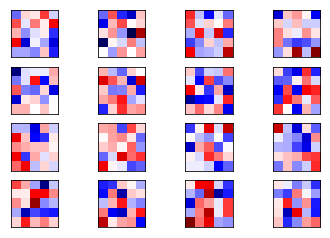

In [32]:
plot_conv_weights(weights=weights_conv1)

Realiza 10.000 iteraciones de optimización

Ahora realizamos 10.000 iteraciones de optimización y cancelamos la optimización si no se encuentra ninguna mejora en el conjunto de validación en 1000 iteraciones.

Se muestra un asterisco * si la precisión de la clasificación en el conjunto de validación es una mejora.

In [33]:
optimize(num_iterations=10000)

Iter:    100, Train-Batch Accuracy:  81.2%, Validation Acc:  84.2% *
Iter:    200, Train-Batch Accuracy:  95.3%, Validation Acc:  90.5% *
Iter:    300, Train-Batch Accuracy:  95.3%, Validation Acc:  92.4% *
Iter:    400, Train-Batch Accuracy:  92.2%, Validation Acc:  92.5% *
Iter:    500, Train-Batch Accuracy:  93.8%, Validation Acc:  94.3% *
Iter:    600, Train-Batch Accuracy:  95.3%, Validation Acc:  94.9% *
Iter:    700, Train-Batch Accuracy:  95.3%, Validation Acc:  95.4% *
Iter:    800, Train-Batch Accuracy:  95.3%, Validation Acc:  95.8% *
Iter:    900, Train-Batch Accuracy:  98.4%, Validation Acc:  96.4% *
Iter:   1000, Train-Batch Accuracy: 100.0%, Validation Acc:  96.2% 
Iter:   1100, Train-Batch Accuracy:  98.4%, Validation Acc:  96.7% *
Iter:   1200, Train-Batch Accuracy:  92.2%, Validation Acc:  96.7% 
Iter:   1300, Train-Batch Accuracy: 100.0%, Validation Acc:  97.2% *
Iter:   1400, Train-Batch Accuracy:  96.9%, Validation Acc:  97.3% *
Iter:   1500, Train-Batch Accuracy: 

Accuracy on Test-Set: 98.8% (9882 / 10000)
Confusion Matrix:
[[ 976    0    0    0    0    1    1    0    1    1]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   4    3 1008    2    1    0    0    4    9    1]
 [   2    0    0  999    0    5    0    0    3    1]
 [   0    0    0    0  975    0    0    0    3    4]
 [   2    0    0    4    0  883    1    0    0    2]
 [  10    2    0    1    1    4  938    0    2    0]
 [   1    0    4    3    0    1    0 1015    1    3]
 [   4    0    0    0    0    2    0    2  962    4]
 [   1    3    0    1    6    3    0    1    0  994]]


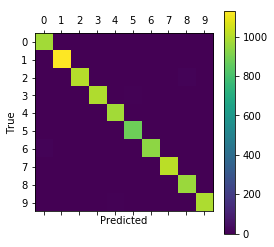

In [34]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Miramos los pesos después de la optimización

Mean: 0.01089, Stdev: 0.29140


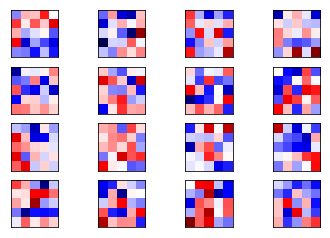

In [35]:
plot_conv_weights(weights=weights_conv1)

### Inicializar variables nuevamente

Reinicializar todas las variables de la red neuronal con valores aleatorios.

Accuracy on Test-Set: 6.7% (673 / 10000)
Mean: 0.02489, Stdev: 0.27997


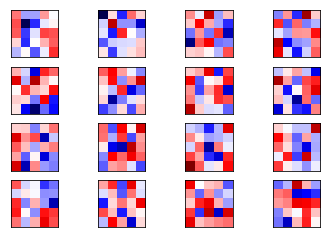

In [38]:
init_variables()
print_test_accuracy()
plot_conv_weights(weights=weights_conv1)

Los pesos convolucionales ahora deberían ser diferentes de los pesos mostrados arriba. Además vemos que la precisión cayo del 98.8% al 6.7%, dado que ahora no se han optimizado los pesos.

## Recuperamos los valores  mejores de las variables del grafo.

Vamos  a cargar todas las variables que se guardaron en el archivo durante la optimización.

In [39]:
saver.restore(sess=session, save_path=save_path)

INFO:tensorflow:Restoring parameters from checkpoints/best_validation


Miaramos la precisión nuevamente

Accuracy on Test-Set: 98.8% (9884 / 10000)
Confusion Matrix:
[[ 974    0    0    0    0    0    3    0    2    1]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   2    3 1015    2    1    0    0    3    6    0]
 [   1    0    1 1002    0    2    0    2    1    1]
 [   0    0    0    0  975    0    2    0    3    2]
 [   2    0    0    6    0  881    1    0    0    2]
 [   4    1    0    1    1    1  950    0    0    0]
 [   1    1    5    2    0    1    0 1014    1    3]
 [   4    0    1    3    1    3    1    2  956    3]
 [   1    3    0    1   10    2    0    6    1  985]]


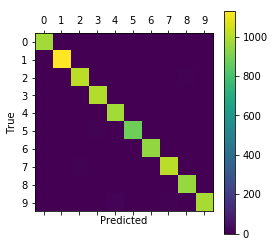

In [43]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

cerramos la sesión para liberar recursos.

In [45]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
session.close()



### Conclusión

Este tutorial mostró cómo guardar y recuperar las variables de una red neuronal en TensorFlow. Esto se puede usar de diferentes maneras. Por ejemplo, si desea utilizar una red neuronal para reconocer imágenes, solo debe entrenar la red una vez y luego puede implementar la red terminada en otras computadoras.

Otro uso de los puntos de control es que si tiene una red neuronal y un conjunto de datos muy grandes, puede guardar los puntos de control a intervalos regulares en caso de que la computadora falle, por lo que puede continuar la optimización en un punto de control reciente en lugar de tener que reiniciar optimización desde el principio.

Este tutorial también mostró cómo usar el conjunto de validación para la llamada  téctica de **Early Stopping**., donde la optimización se anuló si no mejoraba regularmente el error de validación. Esto es útil si la red neuronal comienza a sobreajustarse y aprender el ruido del conjunto de entrenamiento; aunque no fue realmente un problema con la red convolucional y el conjunto de datos MNIST utilizado en este tutorial.

